In [8]:
from plots.loader import load_timings, load_algorithm
import pandas as pd
import numpy as np
from pathlib import Path

paths = {
    "2": Path("measurements/vas_stokes_1M/sections/64-2"),
    "64": Path("measurements/vas_stokes_1M/sections/64-64"),
    "128": Path("measurements/vas_stokes_1M/sections/64-128"),
    "256": Path("measurements/vas_stokes_1M/sections/64-256"),
    "512": Path("measurements/vas_stokes_1M/sections/64-512"),
    "1024": Path("measurements/vas_stokes_1M/sections/64-1024"),
    "1024-shuffled": Path("measurements/vas_stokes_1M/sections/64-1024-with-500-shuffle"),
}
bps = { key: load_timings(path) for key, path in paths.items() }
nodes = 64

for key, bp in bps.items():
    assert load_algorithm(paths[key]) == 'drop_at_once_parallel'
    assert len(bp) == nodes

In [9]:
import matplotlib.pyplot as plt

# SCALING_FACTOR = 10**9 # for seconds
SCALING_FACTOR = 10**6
plt.rcParams['font.family'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
STYLES = {
    # color, marker, offst, name
    "comm": 'tab:blue',
    "mult": 'tab:orange',
    "other": 'tab:green',
    "wait": 'tab:grey'
}

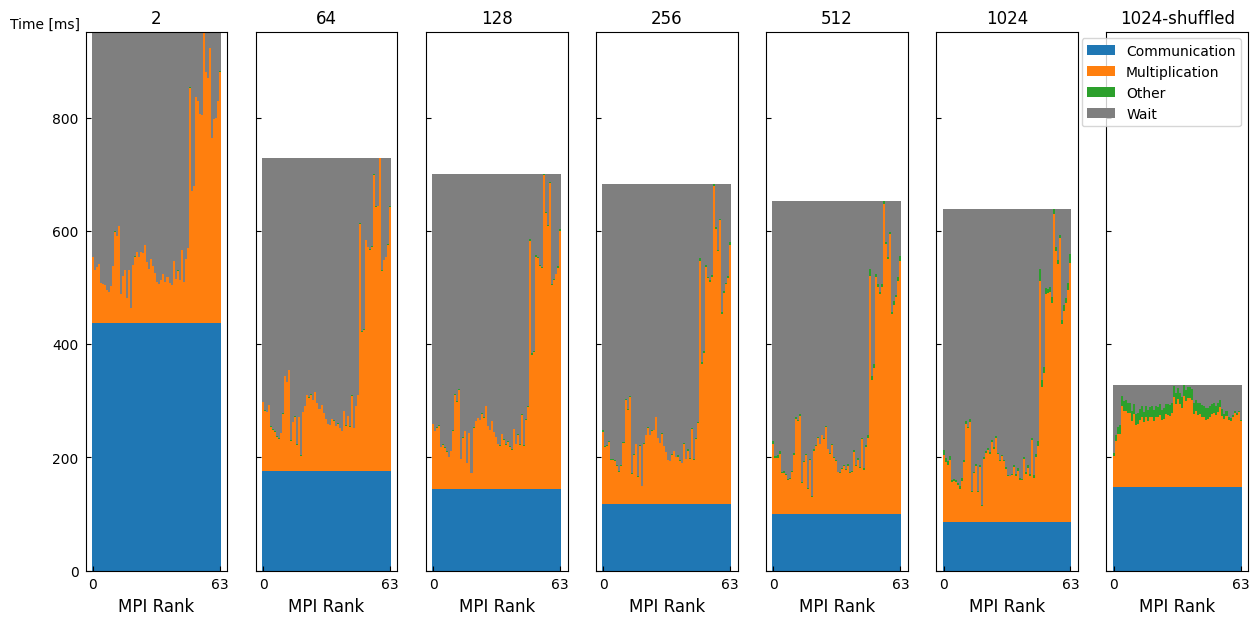

In [10]:
fig, axs = plt.subplots(1, len(bps), sharey=True, figsize=(1+2*len(bps), 7))

i = 0
for name, bp in bps.items():
    ax = axs[i]
    m = max([df[df['func'] == 'gemm']['duration'].mean() for df in bp.values()])/SCALING_FACTOR

    timings = []
    for key, df in bp.items():
        wait_s = df[df['func'] == 'wait_all']['duration']
        wait = (wait_s.mean())/SCALING_FACTOR # *nodes if drop_parallel
        mult_s = df[df['func'] == 'mult']['duration']
        mult = (mult_s.mean() * nodes)/SCALING_FACTOR
        gemm_s = df[df['func'] == 'gemm']['duration']
        gemm = gemm_s.mean()/SCALING_FACTOR
        timings.append({
            "key": key,
            "comm": wait,
            "mult": mult,
            "other": gemm - mult - wait,
            "wait": m - gemm,
        })

    timings = pd.DataFrame(timings)

    keys = timings["key"]
    bottom = np.zeros(len(timings))
    for key, pretty_key in (('comm', 'Communication'), ('mult', 'Multiplication'), ('other', 'Other'), ('wait', 'Wait')):
        ax.bar(keys, timings[key], 1.0, label=pretty_key, bottom=bottom, color=STYLES[key])
        bottom += timings[key]

    ax.set_xlabel("MPI Rank", fontsize=12)
    if i == 0:
        ax.set_ylabel('Time [ms]',
                rotation='horizontal',
                loc='top',
                labelpad=-20)
    
    ax.set_title(name)

    ax.tick_params(axis='both', direction='in', which='major', pad=5)
    xs = [0,nodes-1]
    ax.get_xaxis().set_ticks(xs, labels=xs)
    i += 1

plt.legend()